In [163]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd
from pprint import PrettyPrinter

load_dotenv()
mongo_uri = os.getenv("MONGO_URI")
client = MongoClient(mongo_uri)

pp = PrettyPrinter()
# pp.pprint(list(client.list_databases()))

db = client['sample_supplies']

# print(db.list_collection_names())
sales = db["sales"]

# Check if any inserted data exist in PyMongo
if sales.find_one({"experimentFlag": True}):
    # Delete all experimental rows
    result = sales.delete_many({"experimentFlag": True})
    print(f"Removed {result.deleted_count} synthetic documents.")
else:
    print("No synthetic documents found — starting fresh.")

n_documents = sales.count_documents({})
print(f"{n_documents} documents found.")

one_document = sales.find_one()
one_document


Removed 451 synthetic documents.
5000 documents found.


{'_id': ObjectId('5bd761dcae323e45a93ccfe8'),
 'saleDate': datetime.datetime(2015, 3, 23, 21, 6, 49, 506000),
 'items': [{'name': 'printer paper',
   'tags': ['office', 'stationary'],
   'price': Decimal128('40.01'),
   'quantity': 2},
  {'name': 'notepad',
   'tags': ['office', 'writing', 'school'],
   'price': Decimal128('35.29'),
   'quantity': 2},
  {'name': 'pens',
   'tags': ['writing', 'office', 'school', 'stationary'],
   'price': Decimal128('56.12'),
   'quantity': 5},
  {'name': 'backpack',
   'tags': ['school', 'travel', 'kids'],
   'price': Decimal128('77.71'),
   'quantity': 2},
  {'name': 'notepad',
   'tags': ['office', 'writing', 'school'],
   'price': Decimal128('18.47'),
   'quantity': 2},
  {'name': 'envelopes',
   'tags': ['stationary', 'office', 'general'],
   'price': Decimal128('19.95'),
   'quantity': 8},
  {'name': 'envelopes',
   'tags': ['stationary', 'office', 'general'],
   'price': Decimal128('8.08'),
   'quantity': 3},
  {'name': 'binder',
   'tags': ['sc

In [164]:
cursor = sales.find(
    {},
    {
        "_id": 0,
        "saleDate": 1,
        "storeLocation": 1,
        "couponUsed": 1,
        "purchaseMethod": 1,
        "customer": 1,
        "items": 1,
    },
)
df = pd.DataFrame(list(cursor)).dropna()
df.head()

,saleDate,items,storeLocation,customer,couponUsed,purchaseMethod
0,2015-03-23 21:06:49.506,"[{'name': 'printer paper', 'tags': ['office', ...",Denver,"{'gender': 'M', 'age': 42, 'email': 'cauho@wit...",True,Online
1,2015-08-25 10:01:02.918,"[{'name': 'envelopes', 'tags': ['stationary', ...",Seattle,"{'gender': 'M', 'age': 50, 'email': 'keecade@h...",False,Phone
2,2017-06-22 09:54:14.185,"[{'name': 'notepad', 'tags': ['office', 'writi...",Denver,"{'gender': 'M', 'age': 51, 'email': 'worbiduh@...",False,In store
3,2015-02-23 09:53:59.343,"[{'name': 'binder', 'tags': ['school', 'genera...",Seattle,"{'gender': 'F', 'age': 45, 'email': 'vatires@t...",False,In store
4,2017-12-03 18:39:48.253,"[{'name': 'backpack', 'tags': ['school', 'trav...",London,"{'gender': 'M', 'age': 40, 'email': 'dotzu@ib....",False,In store


In [165]:
df["age"] = df["customer"].apply(lambda x: x.get("age"))
df["customer_email"] = df["customer"].apply(lambda x: x.get("email"))
df["itemsNamesStr"] = df["items"].apply(
    lambda lst: ", ".join(d.get("name", "") for d in lst) if isinstance(lst, list) else ""
)
df.head()



,saleDate,items,storeLocation,customer,couponUsed,purchaseMethod,age,customer_email,itemsNamesStr
0,2015-03-23 21:06:49.506,"[{'name': 'printer paper', 'tags': ['office', ...",Denver,"{'gender': 'M', 'age': 42, 'email': 'cauho@wit...",True,Online,42,cauho@witwuta.sv,"printer paper, notepad, pens, backpack, notepa..."
1,2015-08-25 10:01:02.918,"[{'name': 'envelopes', 'tags': ['stationary', ...",Seattle,"{'gender': 'M', 'age': 50, 'email': 'keecade@h...",False,Phone,50,keecade@hem.uy,"envelopes, binder, notepad, laptop, notepad, p..."
2,2017-06-22 09:54:14.185,"[{'name': 'notepad', 'tags': ['office', 'writi...",Denver,"{'gender': 'M', 'age': 51, 'email': 'worbiduh@...",False,In store,51,worbiduh@vowbu.cg,"notepad, binder, notepad, pens, printer paper,..."
3,2015-02-23 09:53:59.343,"[{'name': 'binder', 'tags': ['school', 'genera...",Seattle,"{'gender': 'F', 'age': 45, 'email': 'vatires@t...",False,In store,45,vatires@ta.pe,"binder, pens, backpack, printer paper, notepad..."
4,2017-12-03 18:39:48.253,"[{'name': 'backpack', 'tags': ['school', 'trav...",London,"{'gender': 'M', 'age': 40, 'email': 'dotzu@ib....",False,In store,40,dotzu@ib.sh,"backpack, notepad, binder, pens, notepad, enve..."


In [166]:
# storeLocation
segment_storeLocation = (
    df
    .groupby(["storeLocation"])
    .agg(
        n_sales=("couponUsed","count"),
        n_coupon=("couponUsed","sum")
    )
    .reset_index()
)
segment_storeLocation["pct_coupon"] = segment_storeLocation["n_coupon"] / segment_storeLocation["n_sales"] * 100

segment_storeLocation.head()

,storeLocation,n_sales,n_coupon,pct_coupon
0,Austin,676,58,8.579882
1,Denver,1549,157,10.135571
2,London,794,76,9.571788
3,New York,501,56,11.177645
4,San Diego,346,27,7.803468


In [167]:
# purchaseMethod
bins = [0,18,25,35,50,65,120]
labels = ["<18","18–24","25–34","35–49","50–64","65+"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

segments_age = (
    df
    .groupby(["age_group"])
    .agg(
        n_sales=("couponUsed","count"),
        n_coupon=("couponUsed","sum")
    )
    .reset_index()
)
segments_age["pct_coupon"] = segments_age["n_coupon"] / segments_age["n_sales"] * 100

segments_age.head()


/var/folders/m_/3l9pb3g94g1gx4rz20ndgyj40000gn/T/ipykernel_9273/1785951656.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_group"])


,age_group,n_sales,n_coupon,pct_coupon
0,<18,120,12,10.000000
1,18–24,374,34,9.090909
2,25–34,943,101,10.710498
3,35–49,1837,177,9.635275
4,50–64,1289,121,9.387122


In [168]:
# purchaseMethod

segments_purchase_method = (
    df
    .groupby(["purchaseMethod"])
    .agg(
        n_sales=("couponUsed","count"),
        n_coupon=("couponUsed","sum")
    )
    .reset_index()
)
segments_purchase_method["pct_coupon"] = segments_purchase_method["n_coupon"] / segments_purchase_method["n_sales"] * 100

segments_purchase_method

,purchaseMethod,n_sales,n_coupon,pct_coupon
0,In store,2819,266,9.435970
1,Online,1585,148,9.337539
2,Phone,596,63,10.570470


/var/folders/m_/3l9pb3g94g1gx4rz20ndgyj40000gn/T/ipykernel_9273/3783229284.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_group","purchaseMethod"])


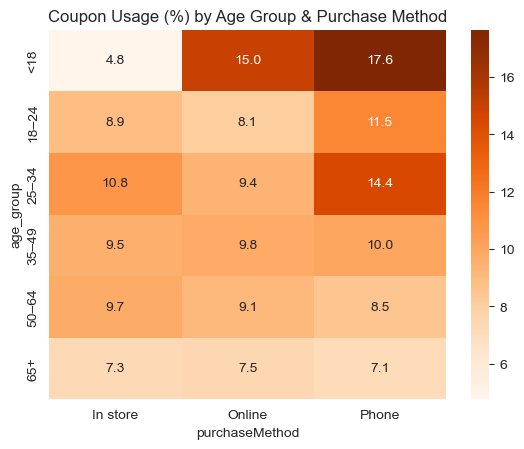

In [169]:
segments = (
    df
    .groupby(["age_group","purchaseMethod"])
    .agg(
        n_sales=("couponUsed","count"),
        n_coupon=("couponUsed","sum"),
    )
    .reset_index()
)
segments["pct_coupon"] = segments["n_coupon"] / segments["n_sales"] * 100



import seaborn as sns
import matplotlib.pyplot as plt

pivot = segments.pivot_table(
    index="age_group",
    columns="purchaseMethod",
    values="pct_coupon",
    aggfunc="mean",
    observed=False
)
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Oranges")
plt.title("Coupon Usage (%) by Age Group & Purchase Method")
plt.show()


In [170]:
# Under-18 shoppers stand out.
#
# They redeem coupons far more often when buying online or by phone than in-store.
#
# Phone purchases generally skew higher.
#
# Middle-age bands (25-64) hover around 9–14 % coupon usage.
#
# 65 + group is lowest overall, especially by phone .

from statsmodels.stats.power import GofChisquarePower
import numpy as np
import math

# power calculation to determine effective size
chi_square_power = GofChisquarePower()
group_size = math.ceil(chi_square_power.solve_power(effect_size=0.2, alpha=0.05, power=0.8))

print("Group size", group_size)
print("Total # of applicants needed", group_size * 2)

Group size 197
Total # of applicants needed 394


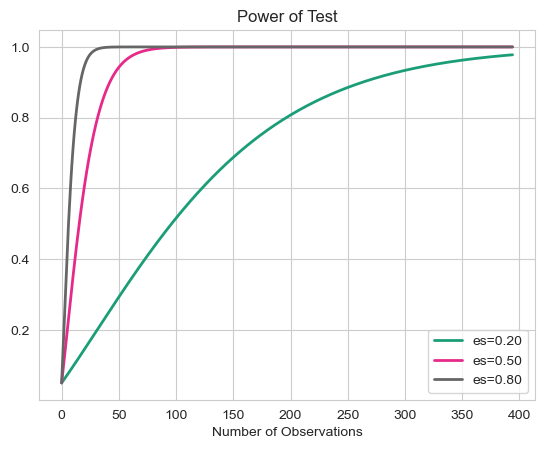

In [171]:
n_observations = np.arange(0, group_size * 2 + 1)
effective_sizes = np.array([0.2, 0.5, 0.8])

# power curve using chi_square_power
chi_square_power.plot_power(
    dep_var="nobs",
    nobs=n_observations,
    effect_size=effective_sizes,
    alpha=0.05,
    n_bins=2,
);

In [172]:
# since we would like to detect even the smaller effects we will use effect size = 0.2 meaning about 400(2 * group_size) observations is required in total

# how long would it take to have this number of observations
result = sales.aggregate(
    [
        {"$match": {"couponUsed": False}},
        {
            "$group": {
                "_id": {"$dateTrunc": {"date": "$saleDate", "unit": "day"}},
                "count": {"$sum": 1}
            }
        }
    ]
)

docs = list(result)
print(type(result))

no_coupon_sales_per_day = (pd.DataFrame(docs)
                 .rename(columns={"_id": "date", "count": "no_couponUsed"})
                 .set_index("date")
                 .sort_index()
                 .squeeze()
)

# print(sales_no_couponUsed_per_day.count())
no_coupon_sales_per_day.head()

<class 'pymongo.synchronous.command_cursor.CommandCursor'>


date
2013-01-01    3
2013-01-02    6
2013-01-04    3
2013-01-06    2
2013-01-07    2
Name: no_couponUsed, dtype: int64

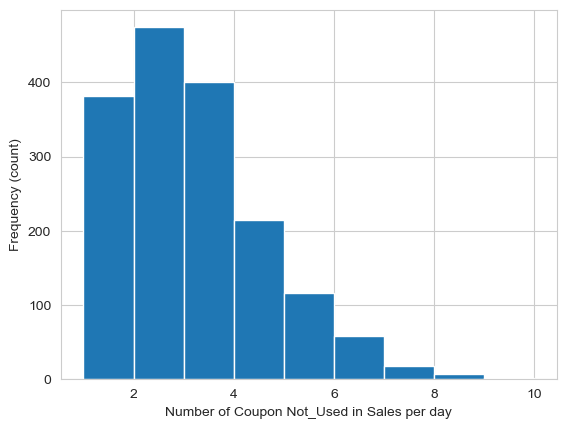

In [173]:
no_coupon_sales_per_day.hist(bins=range(int(no_coupon_sales_per_day.min()),
               int(no_coupon_sales_per_day.max()) + 2))

plt.xlabel("Number of Coupon Not_Used in Sales per day")
plt.ylabel("Frequency (count)");

In [174]:
# from the histogram we can clearly see we have somewhere between 2 and 9 sales per day with no coupon

mean = no_coupon_sales_per_day.describe()['mean']
std = no_coupon_sales_per_day.describe()['std']
print(mean)
no_coupon_sales_per_day.describe()['std']


2.7051435406698565


1.467304910952635

In [175]:
# considering the mean(2.705) and std(1.467), we will need 400 / (2.705+_1.467) days to carry out our experiment to have statistically significant result

days = np.array([100, 200, 300, 400, 500])

sum_mean = round(mean) * days
sum_std = round(std) * np.sqrt(days)

print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: [ 300  600  900 1200 1500]
Std of sum: [10.         14.14213562 17.32050808 20.         22.36067977]


In [176]:
import scipy

# cdf_value = use CDF to get probability of 400 observations or fewer
# 1 - cdf_vale = probability of 400 observations or more

prob_400_fewer = scipy.stats.norm.cdf(
    group_size * 2,
    sum_mean,
    sum_std
)

prob_400_more = 1 - prob_400_fewer

print(f"Prob 400 or more in {days} days:", prob_400_more)

Prob 400 or more in [100 200 300 400 500] days: [0. 1. 1. 1. 1.]


In [177]:
# prob_400_more in 200days = 1.0, we can conduct our experiment for 200days
from datetime import timedelta

last_date = sales.find_one(sort=[("saleDate", -1)])["saleDate"]
exp_start = last_date + timedelta(days=1)
exp_end   = exp_start + timedelta(days=200)
print(exp_start, exp_end)


2018-01-01 18:15:34.758000 2018-07-20 18:15:34.758000


In [178]:
# 200days experiment synthesized with random coupon usage
import numpy as np

n_total = 400
days    = 200
mean_per_day = n_total // days

# remove every document previously tagged as part of the experiment
sales.delete_many({"experimentFlag": True})

def age_to_group(age):
    if age < 18:   return "<18"
    elif age < 25: return "18–24"
    elif age < 35: return "25–34"
    elif age < 50: return "35–49"
    elif age < 65: return "50–64"
    else:          return "65+"

new_rows = []
for d in range(days):
    sale_date = exp_start + timedelta(days=d)

    # ensure at least one record per day
    n_today = max(1, np.random.poisson(mean_per_day))

    for _ in range(n_today):
        # sample an existing record as a template
        template = sales.aggregate([{"$sample": {"size": 1}}]).next()

        # create a clean copy without the original _id
        new_doc = {k: v for k, v in template.items() if k != "_id"}

        new_doc["saleDate"] = sale_date
        new_doc["experimentFlag"] = True
        new_doc["couponUsed"] = bool(np.random.choice([True, False],
                                                     p=[0.45, 0.55]))
        # derive age_group from the customer’s age
        cust_age = new_doc.get("customer", {}).get("age")
        if cust_age is not None:
            new_doc["age_group"] = age_to_group(cust_age)

        #improve Item quantities
        boosted_items = []
        for item in new_doc.get("items", []):
            item_copy = item.copy()
            # increase quantity by 20–50% (at least +1)
            factor = np.random.uniform(1.2, 1.5)
            old_q = item_copy.get("quantity", 1)
            new_q = max(1, int(round(old_q * factor)))
            item_copy["quantity"] = new_q
            boosted_items.append(item_copy)
            new_doc["items"] = boosted_items
        new_rows.append(new_doc)

# insert new rows to collections
if new_rows:
    sales.insert_many(new_rows)
    print(f"Inserted {len(new_rows)} synthetic experiment docs.")
else:
    print("No new rows generated.")


Inserted 410 synthetic experiment docs.


In [179]:
doc = sales.find_one({"experimentFlag": True})
print(doc)


{'_id': ObjectId('68dc8687a1418801326b94c2'), 'saleDate': datetime.datetime(2018, 1, 1, 18, 15, 34, 758000), 'items': [{'name': 'laptop', 'tags': ['electronics', 'school', 'office'], 'price': Decimal128('1525.66'), 'quantity': 6}, {'name': 'binder', 'tags': ['school', 'general', 'organization'], 'price': Decimal128('14.51'), 'quantity': 9}], 'storeLocation': 'Seattle', 'customer': {'gender': 'M', 'age': 57, 'email': 'diice@tocpavej.gr', 'satisfaction': 3}, 'couponUsed': False, 'purchaseMethod': 'In store', 'experimentFlag': True, 'age_group': '50–64'}


In [180]:
result = sales.find({"experimentFlag": True},{
        "_id": 0,
        "saleDate": 1,
        "storeLocation": 1,
        "couponUsed": 1,
        "purchaseMethod": 1,
        "customer": 1,
        "items": 1,
        "experimentFlag": 1,
        "age_group": 1,
    })
df = pd.DataFrame(result).dropna()
df.head()

,saleDate,items,storeLocation,customer,couponUsed,purchaseMethod,experimentFlag,age_group
0,2018-01-01 18:15:34.758,"[{'name': 'laptop', 'tags': ['electronics', 's...",Seattle,"{'gender': 'M', 'age': 57, 'email': 'diice@toc...",False,In store,True,50–64
1,2018-01-02 18:15:34.758,"[{'name': 'printer paper', 'tags': ['office', ...",London,"{'gender': 'M', 'age': 30, 'email': 'wipo@petv...",True,Online,True,25–34
2,2018-01-02 18:15:34.758,"[{'name': 'laptop', 'tags': ['electronics', 's...",Austin,"{'gender': 'M', 'age': 40, 'email': 'wij@baptu...",False,Online,True,35–49
3,2018-01-02 18:15:34.758,"[{'name': 'notepad', 'tags': ['office', 'writi...",San Diego,"{'gender': 'F', 'age': 36, 'email': 'ba@ge.to'...",True,In store,True,35–49
4,2018-01-03 18:15:34.758,"[{'name': 'notepad', 'tags': ['office', 'writi...",Seattle,"{'gender': 'F', 'age': 50, 'email': 'vom@opgu....",False,Phone,True,50–64


In [181]:

exp = pd.DataFrame(list(sales.find({"experimentFlag": True}, {"couponUsed":1})))
base= pd.DataFrame(list(sales.find({"experimentFlag": {"$exists": False}}, {"couponUsed":1})))
exp_df  = pd.DataFrame({"coupon": exp["couponUsed"],  "group": "experiment"})
base_df = pd.DataFrame({"coupon": base["couponUsed"], "group": "control"})
all_df  = pd.concat([exp_df, base_df], ignore_index=True)

data_df = pd.crosstab(all_df["coupon"], all_df["group"])

from statsmodels.stats.contingency_tables import Table2x2

contingency_table = Table2x2(data_df.values)

# print(contingency_table.fitted_values)

# contingency_table.independence_probabilities.round(3)

chi_square_test_result = contingency_table.test_nominal_association()
print(chi_square_test_result)
# all_df.head()

df          1
pvalue      0.0
statistic   452.28424655659353


In [182]:
# since our p_value=0.0 is less than 0.05
# We reject the null hypothesis(there is significant difference in sending reminder to use coupon to our customers

summary = contingency_table.summary()
summary

,Estimate,SE,LCB,UCB,p-value
Odds ratio,7.874,,6.343,9.773,0.000
Log odds ratio,2.064,0.110,1.847,2.280,0.000
Risk ratio,1.324,,1.262,1.389,0.000
Log risk ratio,0.281,0.024,0.233,0.329,0.000


In [183]:
segments_exp = (
    df
    .groupby(["age_group","purchaseMethod"])
    .agg(
        n_sales=("couponUsed","count"),
        n_coupon=("couponUsed","sum")
    )
    .reset_index()
)
segments_exp["pct_coupon"] = (segments_exp["n_coupon"] / segments_exp["n_sales"]) * 100

segments_exp.head()


,age_group,purchaseMethod,n_sales,n_coupon,pct_coupon
0,18–24,In store,17,10,58.823529
1,18–24,Online,6,4,66.666667
2,18–24,Phone,9,2,22.222222
3,25–34,In store,36,17,47.222222
4,25–34,Online,25,11,44.000000


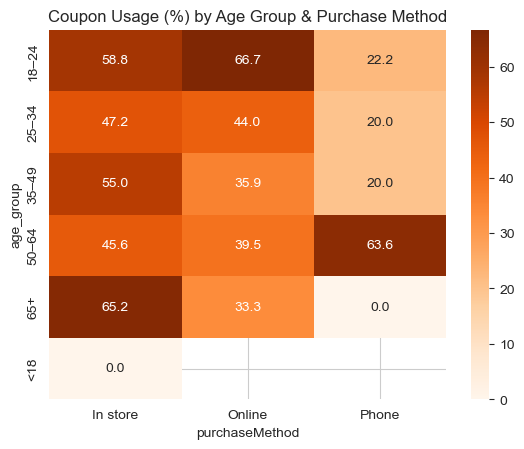

In [184]:
pivot = segments_exp.pivot_table(
    index="age_group",
    columns="purchaseMethod",
    values="pct_coupon",
    aggfunc="mean",
    observed=False
)
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Oranges")
plt.title("Coupon Usage (%) by Age Group & Purchase Method")
plt.show()


In [185]:
import pandas as pd

# Control = original data
control_df = pd.DataFrame(list(
    sales.find({"experimentFlag": {"$ne": True}},
               {"_id":0,"items":1,"couponUsed":1})
))

# Experiment = synthetic group
exp_df = pd.DataFrame(list(
    sales.find({"experimentFlag": True},
               {"_id":0,"items":1,"couponUsed":1})
))

def order_total(items):
    return sum(float(it["price"].to_decimal()) * it["quantity"] for it in items)

control_df["sale_amount"] = control_df["items"].apply(order_total)
exp_df["sale_amount"]     = exp_df["items"].apply(order_total)


baseline_avg   = control_df["sale_amount"].mean()
experiment_avg = exp_df["sale_amount"].mean()

baseline_total = control_df["sale_amount"].sum()
experiment_total = exp_df["sale_amount"].sum()

lift = (experiment_avg - baseline_avg) / baseline_avg * 100


def coupon_stats(df):
    with_coupon    = df[df["couponUsed"]]
    without_coupon = df[~df["couponUsed"]]
    return {
        "mean_with_coupon":    with_coupon["sale_amount"].mean(),
        "mean_without_coupon": without_coupon["sale_amount"].mean(),
        "usage_rate":          with_coupon.shape[0] / df.shape[0] * 100
    }

control_stats = coupon_stats(control_df)
experiment_stats = coupon_stats(exp_df)
print(control_stats, experiment_stats)
print(lift)

{'mean_with_coupon': 2034.3766876310274, 'mean_without_coupon': 1973.0653526420517, 'usage_rate': 9.54} {'mean_with_coupon': 2857.5190860215057, 'mean_without_coupon': 2422.430714285714, 'usage_rate': 45.36585365853659}
32.38633246612703


In [186]:
control_avg_sale = control_df["sale_amount"].sum() / len(control_df["sale_amount"])
experiment_avg_sale = exp_df["sale_amount"].sum() / len(exp_df["sale_amount"])
print(control_avg_sale)
print(experiment_avg_sale)

1978.914454
2619.8122682926823
